In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.stats import binom
from scipy.special import comb
from scipy.stats import binom_test
from scipy.stats import norm

In [4]:
def load_predictions(path, n=5):
    preds = []
    for i in range(n):
        preds.append(pd.read_csv(path.format(i), index_col=0))
    preds = pd.concat(preds).groupby(level=0).mean()    
    return preds

In [5]:
ls /home/gemeinl/results/all_recs_100_hz/features/asc/pathological/

automl_object_after_refit.pkl   probas_eval.csv
automl_object_before_refit.pkl  show_models_after_refit.pkl
autosklearn_cv_example_out/     show_models_beore_refit.pkl
autosklearn_cv_example_tmp/     statistics.txt
predictions_eval.csv


In [6]:
deep_preds = load_predictions("/home/gemeinl/results/all_recs_100_hz/networks/deep/pathological/eval/predictions_test_{}.csv")
deep_y_true = deep_preds["true_pathological"]
deep_preds = deep_preds["pathological"] >= deep_preds["non-pathological"]
assert len(deep_preds) == len(deep_y_true)

In [7]:
shallow_preds = load_predictions("/home/gemeinl/results/all_recs_100_hz/networks/shallow/pathological/eval/predictions_test_{}.csv")
shallow_y_true = shallow_preds["true_pathological"]
shallow_preds = shallow_preds["pathological"] >= shallow_preds["non-pathological"]
assert len(shallow_preds) == len(shallow_y_true)

In [8]:
tcn_preds = load_predictions("/home/gemeinl/results/all_recs_100_hz/networks/tcn/pathological/eval/predictions_test_{}.csv")
tcn_y_true = tcn_preds["true_pathological"]
tcn_preds = tcn_preds["pathological"] >= tcn_preds["non-pathological"]
assert len(tcn_preds) == len(tcn_y_true)

In [9]:
eegnet_preds = load_predictions("/home/gemeinl/results/all_recs_100_hz/networks/eegnet/pathological/eval/predictions_test_{}.csv")
eegnet_y_true = eegnet_preds["true_pathological"]
eegnet_preds = eegnet_preds["pathological"] >= eegnet_preds["non-pathological"]
assert len(eegnet_preds) == len(eegnet_y_true)

In [10]:
rf_preds = pd.read_csv("/home/gemeinl/results/all_recs_100_hz/features/rf/pathological/without_age_and_gender/eval/predictions_eval.csv", index_col=0).groupby("group").mean()
rf_y_true = rf_preds["y_true"]
rf_preds = rf_preds["y_pred"] >= .5
assert len(rf_preds) == len(rf_y_true)

In [11]:
svm_preds = pd.read_csv("/home/gemeinl/results/all_recs_100_hz/features/svm/pathological/without_age_and_gender/eval/predictions_eval.csv", index_col=0).groupby("group").mean()
svm_y_true = svm_preds["y_true"]
svm_preds = svm_preds["y_pred"] >= .5
assert len(svm_preds) == len(svm_y_true)

In [12]:
asc_preds = pd.read_csv("/home/gemeinl/results/all_recs_100_hz/features/asc/pathological/probas_eval.csv", index_col=0)
asc_preds = asc_preds["1"] >= .5
assert len(asc_preds) == len(deep_preds)

In [13]:
riemanniam_preds = pd.read_csv("/home/gemeinl/results/all_recs_100_hz/features/riemannian/pathological/eval/predictions_eval.csv", index_col=0)
riemanniam_preds = riemanniam_preds["y_pred"] >= .5
assert len(riemanniam_preds) == len(deep_preds)

In [14]:
(riemanniam_preds == deep_preds).sum()

249

In [15]:
preds_dict = {"RF": rf_preds, "SVM": svm_preds, "BD-Deep4": deep_preds, "BD-Shallow": shallow_preds, "BD-EEGNet": eegnet_preds, "BD-TCN": tcn_preds, "ASC": asc_preds, "RG": riemanniam_preds}

In [16]:
# check that network and feature ground truths are the same
for ix, l in enumerate(deep_y_true):
    assert rf_y_true[ix] == l
y_true = deep_y_true

calculate bootstrap distribution of accuracy

In [17]:
import seaborn as sns
sns.set(color_codes=True)

In [18]:
def bootstrap_dist(y_preds, y_true, n_bootstrap_samples=10000, n_samples_in_bootstrap=100, seed=932020):
    np.random.seed(seed)
    accuracy_bootstrap_dist = []
    for i in range(n_bootstrap_samples):
        rand_ids = np.random.randint(0, len(y_preds), n_samples_in_bootstrap)    
        acc = (y_preds[rand_ids] == y_true[rand_ids]).mean()   *100 
        accuracy_bootstrap_dist.append(acc)
    return np.array(accuracy_bootstrap_dist)

In [19]:
tcn_bootstrap_dist = bootstrap_dist(tcn_preds, tcn_y_true)

In [20]:
rg_bootstrap_dist = bootstrap_dist(riemanniam_preds, rf_y_true)

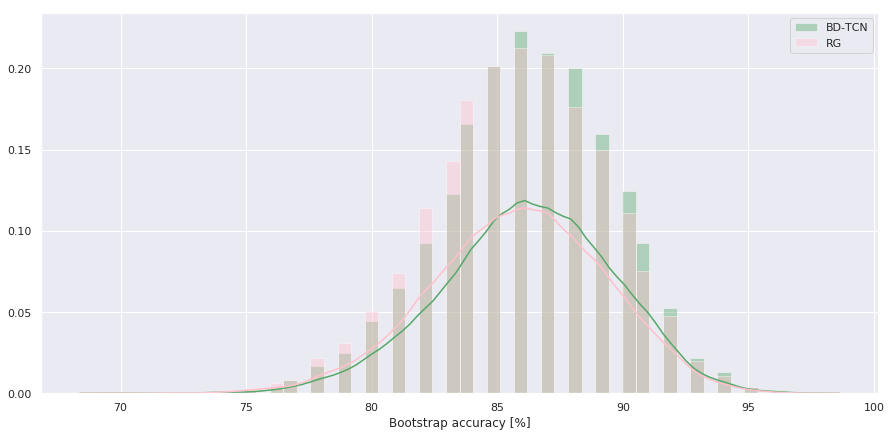

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
sns.distplot(tcn_bootstrap_dist, label="BD-TCN", ax=ax, color="g")
sns.distplot(rg_bootstrap_dist, label="RG", ax=ax, color="pink", axlabel="Bootstrap accuracy [%]")
ax.legend()

In [22]:
deep_bootstrap_dist = bootstrap_dist(deep_preds, deep_y_true)
shallow_bootstrap_dist = bootstrap_dist(shallow_preds, deep_y_true)
eegnet_bootstrap_dist = bootstrap_dist(eegnet_preds, deep_y_true)

In [23]:
rf_bootstrap_dist = bootstrap_dist(rf_preds, rf_y_true)
svm_bootstrap_dist = bootstrap_dist(svm_preds, rf_y_true)
asc_bootstrap_dist = bootstrap_dist(asc_preds, rf_y_true)

[]

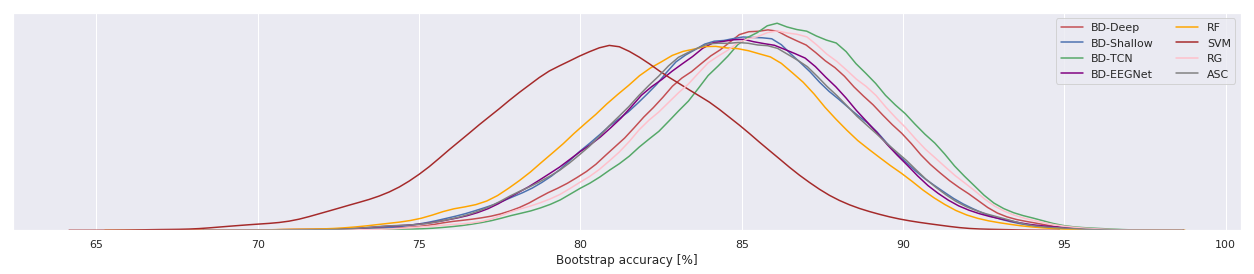

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(22,4))
sns.distplot(deep_bootstrap_dist, label="BD-Deep", hist=False, ax=ax, color="r")
sns.distplot(shallow_bootstrap_dist, label="BD-Shallow", hist=False, ax=ax, color="b")
sns.distplot(tcn_bootstrap_dist, label="BD-TCN", hist=False, ax=ax, color="g")
sns.distplot(eegnet_bootstrap_dist, label="BD-EEGNet", hist=False, ax=ax, color="purple")

sns.distplot(rf_bootstrap_dist, label="RF",  hist=False, ax=ax, color="orange")
sns.distplot(svm_bootstrap_dist, label="SVM",  hist=False, ax=ax, color="brown")
sns.distplot(rg_bootstrap_dist, label="RG",  hist=False, ax=ax, color="pink")
sns.distplot(asc_bootstrap_dist, label="ASC",  hist=False, ax=ax, color="grey", axlabel="Bootstrap accuracy [%]")
ax.legend(ncol=2)
ax.set_yticks([])

fig.savefig("./bootstrap_accuracies.pdf", bbox_inches="tight")

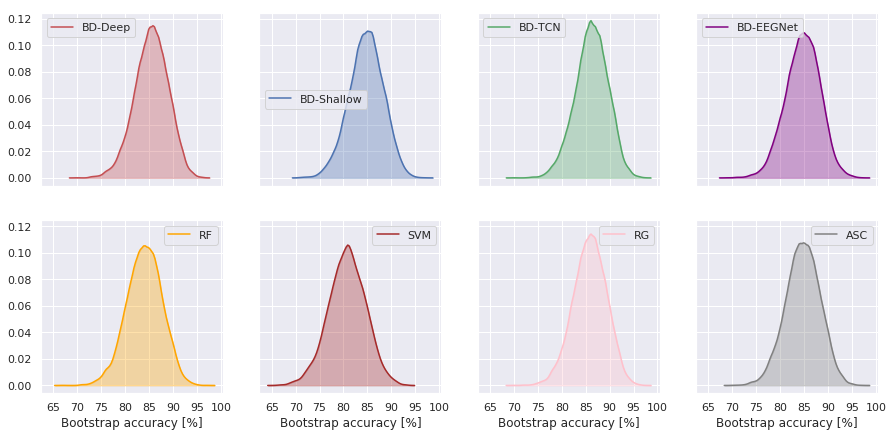

In [25]:
fig, ax_arr = plt.subplots(2, 4, figsize=(15,7), sharex=True, sharey=True)
ax = ax_arr[0,0]
sns.distplot(deep_bootstrap_dist, label="BD-Deep", hist=False, ax=ax, color="r")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="r", alpha=.33)

ax = ax_arr[0,1]
sns.distplot(shallow_bootstrap_dist, label="BD-Shallow", hist=False, ax=ax, color="b")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="b", alpha=.33)

ax = ax_arr[0,2]
sns.distplot(tcn_bootstrap_dist, label="BD-TCN", hist=False, ax=ax, color="g")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="g", alpha=.33)

ax = ax_arr[0,3]
sns.distplot(eegnet_bootstrap_dist, label="BD-EEGNet", hist=False, ax=ax, color="purple")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="purple", alpha=.33)

ax = ax_arr[1,0]
sns.distplot(rf_bootstrap_dist, label="RF",  hist=False, ax=ax, color="orange", axlabel="Bootstrap accuracy [%]")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="orange", alpha=.33)

ax = ax_arr[1,1]
sns.distplot(svm_bootstrap_dist, label="SVM",  hist=False, ax=ax, color="brown", axlabel="Bootstrap accuracy [%]")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="brown", alpha=.33)

ax = ax_arr[1,2]
sns.distplot(rg_bootstrap_dist, label="RG",  hist=False, ax=ax, color="pink", axlabel="Bootstrap accuracy [%]")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="pink", alpha=.33)

ax = ax_arr[1,3]
sns.distplot(asc_bootstrap_dist, label="ASC",  hist=False, ax=ax, color="grey", axlabel="Bootstrap accuracy [%]")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="grey", alpha=.33)
ax.set_xticks([65, 70, 75, 80, 85, 90, 95, 100]);


In [26]:
from itertools import product, permutations, combinations

In [27]:
acc_diffs = []
for a, b in combinations([deep_bootstrap_dist, shallow_bootstrap_dist, tcn_bootstrap_dist, eegnet_bootstrap_dist,
                          rf_bootstrap_dist, svm_bootstrap_dist, rg_bootstrap_dist, asc_bootstrap_dist], r=2):
    acc_diffs.append((a-b).mean())

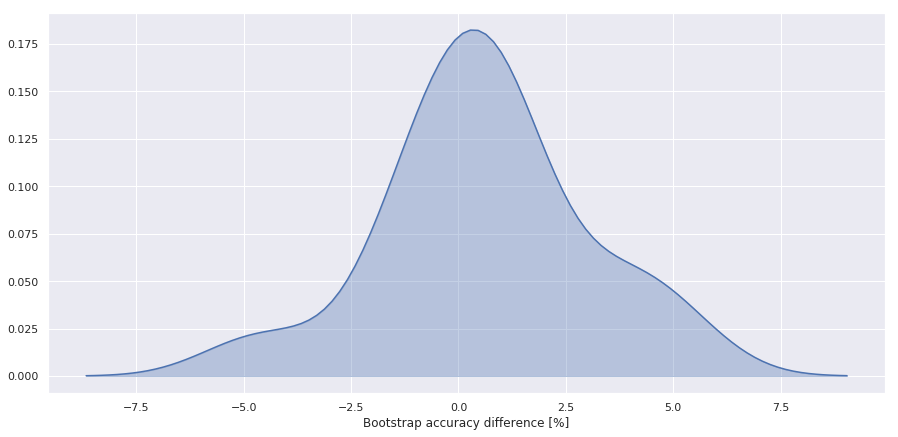

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
sns.distplot(acc_diffs, hist=False, axlabel="Bootstrap accuracy difference [%]", ax=ax)
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="b", alpha=.33)

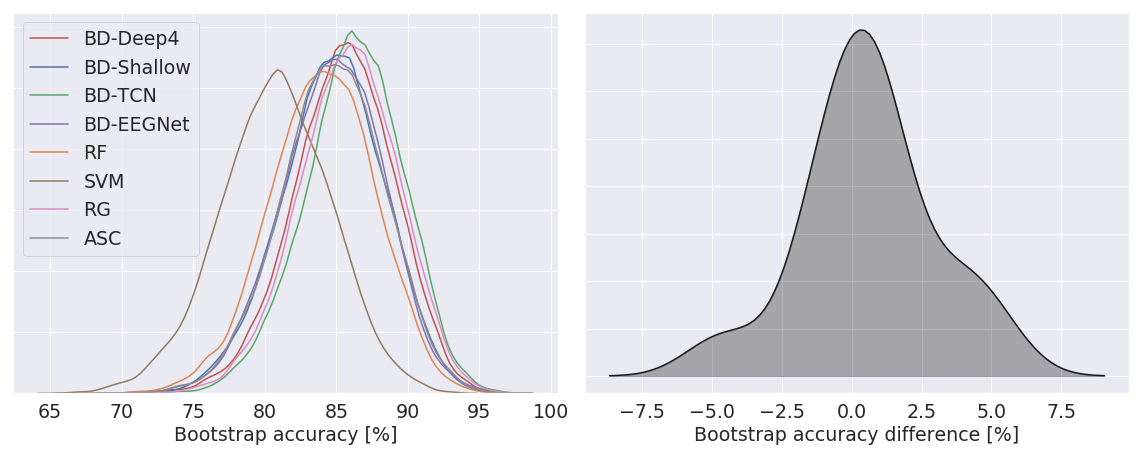

In [29]:
fs = 19
fig, ax_arr = plt.subplots(1, 2, figsize=(20,7))
ax = ax_arr[0]
sns.distplot(deep_bootstrap_dist, label="BD-Deep4", hist=False, ax=ax, color=sns.color_palette()[3])
sns.distplot(shallow_bootstrap_dist, label="BD-Shallow", hist=False, ax=ax, color=sns.color_palette()[0])
sns.distplot(tcn_bootstrap_dist, label="BD-TCN", hist=False, ax=ax, color=sns.color_palette()[2])
sns.distplot(eegnet_bootstrap_dist, label="BD-EEGNet", hist=False, ax=ax, color=sns.color_palette()[4])

sns.distplot(rf_bootstrap_dist, label="RF",  hist=False, ax=ax, color=sns.color_palette()[1])
sns.distplot(svm_bootstrap_dist, label="SVM",  hist=False, ax=ax, color=sns.color_palette()[5])
sns.distplot(rg_bootstrap_dist, label="RG",  hist=False, ax=ax, color=sns.color_palette()[6])
sns.distplot(asc_bootstrap_dist, label="ASC",  hist=False, ax=ax, color=sns.color_palette()[7])
ax.legend(ncol=1, fontsize=fs)
ax.set_yticklabels([])
ax.tick_params(labelsize=fs)
ax.set_xlabel("Bootstrap accuracy [%]", fontsize=fs)

ax = ax_arr[1]
sns.distplot(acc_diffs, hist=False, ax=ax, color="k")
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, color="k", alpha=.33)
ax.set_yticklabels([])
ax.tick_params(labelsize=fs)
ax.set_xlabel("Bootstrap accuracy difference [%]", fontsize=fs)

plt.subplots_adjust(wspace=.05)

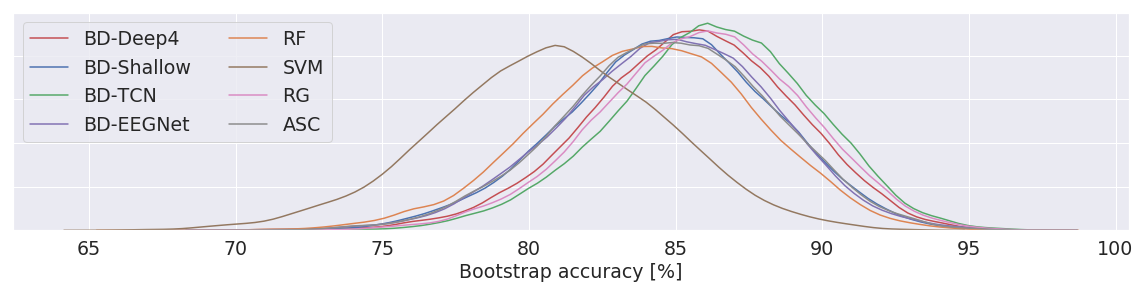

In [30]:
fs = 19
fig, ax = plt.subplots(1, 1, figsize=(20,4))
sns.distplot(deep_bootstrap_dist, label="BD-Deep4", hist=False, ax=ax, color=sns.color_palette()[3])
sns.distplot(shallow_bootstrap_dist, label="BD-Shallow", hist=False, ax=ax, color=sns.color_palette()[0])
sns.distplot(tcn_bootstrap_dist, label="BD-TCN", hist=False, ax=ax, color=sns.color_palette()[2])
sns.distplot(eegnet_bootstrap_dist, label="BD-EEGNet", hist=False, ax=ax, color=sns.color_palette()[4])

sns.distplot(rf_bootstrap_dist, label="RF",  hist=False, ax=ax, color=sns.color_palette()[1])
sns.distplot(svm_bootstrap_dist, label="SVM",  hist=False, ax=ax, color=sns.color_palette()[5])
sns.distplot(rg_bootstrap_dist, label="RG",  hist=False, ax=ax, color=sns.color_palette()[6])
sns.distplot(asc_bootstrap_dist, label="ASC",  hist=False, ax=ax, color=sns.color_palette()[7])
ax.legend(ncol=2, fontsize=fs)
ax.set_yticklabels([])
ax.tick_params(labelsize=fs)
ax.set_xlabel("Bootstrap accuracy [%]", fontsize=fs)

#ax = ax_arr[1]
#sns.distplot(acc_diffs, hist=False, ax=ax, color="k")
#kde_x, kde_y = ax.lines[0].get_data()
#ax.fill_between(kde_x, kde_y, color="k", alpha=.33)
ax.set_yticklabels([])
ax.tick_params(labelsize=fs)
ax.set_xlabel("Bootstrap accuracy [%]", fontsize=fs)

plt.subplots_adjust(wspace=.05)

fig.savefig("bootstrap_distributions.pdf", bbox_inches="tight")

NameError: name 'idxs' is not defined

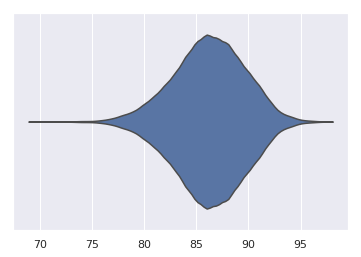

In [31]:
ax = sns.violinplot(tcn_bootstrap_dist, inner=None)
ax = sns.swarmplot(tcn_bootstrap_dist[idxs],
                   color="white", edgecolor="gray")

Text(0.5, 1.0, 'ASC')

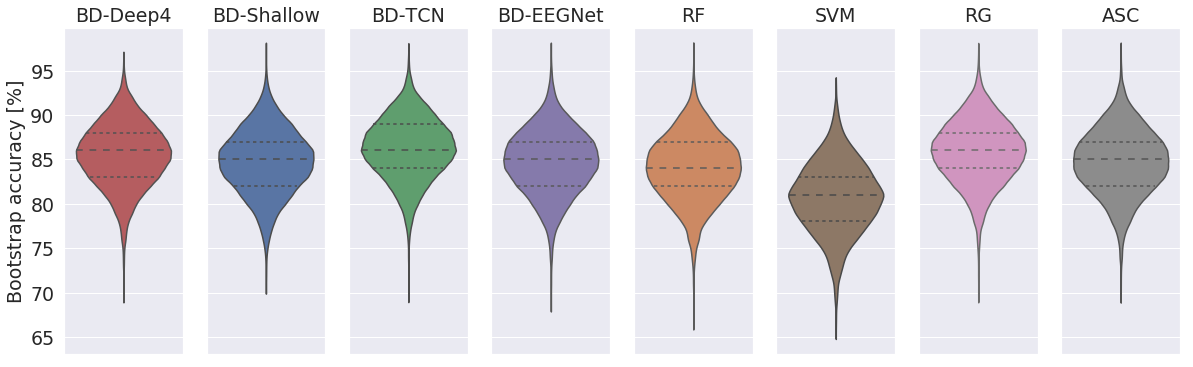

In [32]:
np.random.seed(1)
idxs = np.random.randint(len(tcn_bootstrap_dist), size=100)

fig, ax_arr = plt.subplots(1, 8, figsize=(20,6), sharex=True, sharey=True)

ax=ax_arr[0]
sns.violinplot(deep_bootstrap_dist, ax=ax, scale="width", inner="quartile", color=sns.color_palette()[3], orient="v")
ax.set_title("BD-Deep4", rotation=0, fontsize=fs)
ax.set_ylabel("Bootstrap accuracy [%]", fontsize=fs)
ax.tick_params(labelsize=fs)

ax=ax_arr[1]
sns.violinplot(shallow_bootstrap_dist, ax=ax, scale="width", inner="quartile", color=sns.color_palette()[0], orient="v")
ax.set_title("BD-Shallow", rotation=0, fontsize=fs)

ax=ax_arr[2]
sns.violinplot(tcn_bootstrap_dist, ax=ax, scale="width", inner="quartile", color=sns.color_palette()[2], orient="v")
#sns.swarmplot(tcn_bootstrap_dist[idxs], ax=ax, color="white", edgecolor="gray")
ax.set_title("BD-TCN", rotation=0, fontsize=fs)

ax=ax_arr[3]
sns.violinplot(eegnet_bootstrap_dist, ax=ax, scale="width", inner="quartile", color=sns.color_palette()[4], orient="v")
ax.set_title("BD-EEGNet", rotation=0, fontsize=fs)



ax=ax_arr[4]
sns.violinplot(rf_bootstrap_dist, ax=ax, orient="v", scale="width", inner="quartile", color=sns.color_palette()[1])
ax.set_title("RF", rotation=0, fontsize=fs)

ax=ax_arr[5]
sns.violinplot(svm_bootstrap_dist, ax=ax, orient="v", scale="width", inner="quartile", color=sns.color_palette()[5])
ax.set_title("SVM", rotation=0, fontsize=fs)

ax=ax_arr[6]
sns.violinplot(rg_bootstrap_dist, ax=ax, orient="v", scale="width", inner="quartile", color=sns.color_palette()[6])
ax.set_title("RG", rotation=0, fontsize=fs)

ax=ax_arr[7]
sns.violinplot(asc_bootstrap_dist, ax=ax, orient="v", scale="width", inner="quartile", color=sns.color_palette()[7])
ax.set_title("ASC", rotation=0, fontsize=fs)

fig.savefig("bootstrap_distributions_violins.pdf", bbox_inches="tight")

make a subset performance analysis

adult: > 19 years  
adolescent: 10 - 19 years  
child: < 19  
infant: < 1 year  


In [19]:
import sys
sys.path.insert(0, "/home/gemeinl/code/brainfeatures/")

In [20]:
from brainfeatures.data_set.tuh_abnormal import TuhAbnormal

In [21]:
tuh_eval = TuhAbnormal(data_path="/data/schirrmr/gemeinl/tuh-abnormal-eeg/raw/v2.0.0/edf/eval/", subset="eval", extension=".edf")

In [22]:
tuh_eval.load()

In [23]:
assert len(tuh_eval) == len(tcn_preds)

In [24]:
ages = np.array(tuh_eval.ages)

In [25]:
genders = np.array(tuh_eval.genders)

In [26]:
conditions =  {
    #"child": ages < 19,
    #"adult": (ages >= 19) & (ages < 60),
    #"old": ages >= (60),
    "female young": (ages < 30) & (genders == 1),
    "female middle": (ages >= 30) & (ages < 60) & (genders == 1),
    "female old": (ages >= 60) & (genders == 1),
    "male young": (ages < 30) & (genders == 0),
    "male middle": (ages >= 30) & (ages < 60) & (genders == 0),
    "male old": (ages >= 60) & (genders == 0),    
}

In [27]:
df = pd.DataFrame(columns=["Age", "Gender", "Model", "Accuracy [%]"])

In [28]:
correct_predictions = {
    "BD-Deep4": deep_preds == deep_y_true,
    "BD-Shallow": shallow_preds == deep_y_true,
    "BD-TCN": tcn_preds == deep_y_true,
    "BD-EEGNet": eegnet_preds == deep_y_true,
    "RF": rf_preds == rf_y_true,
    "SVM": svm_preds == rf_y_true,
    "RG": riemanniam_preds == rf_y_true,
    "ASC": asc_preds == rf_y_true
}

In [29]:
for model, correct_predictions in correct_predictions.items():
    for name, cond in conditions.items():
        acc = correct_predictions[cond].mean() * 100
        df = df.append({
            "Age": (" ").join(name.split(" ")[1:]), 
            "Gender": name.split(" ")[0], 
            "Model": model, 
            "Accuracy [%]": acc
        }, ignore_index=True)    

In [30]:
df

,Age,Gender,Model,Accuracy [%]
0,young,female,BD-Deep4,95.000000
1,middle,female,BD-Deep4,85.135135
2,old,female,BD-Deep4,75.925926
3,young,male,BD-Deep4,90.000000
4,middle,male,BD-Deep4,87.179487
5,old,male,BD-Deep4,90.000000
6,young,female,BD-Shallow,95.000000
7,middle,female,BD-Shallow,86.486486
8,old,female,BD-Shallow,72.222222
9,young,male,BD-Shallow,85.000000


In [31]:
import seaborn as sns
sns.set(color_codes=True)

In [32]:
(ages < 30).sum()

40

In [33]:
default_colors = np.array(sns.color_palette()[:8])
palette = default_colors[[3, 0, 2, 4, 1, 5, 6, 7]]
fs = 20

In [34]:
young_age = 30
old_age = 60

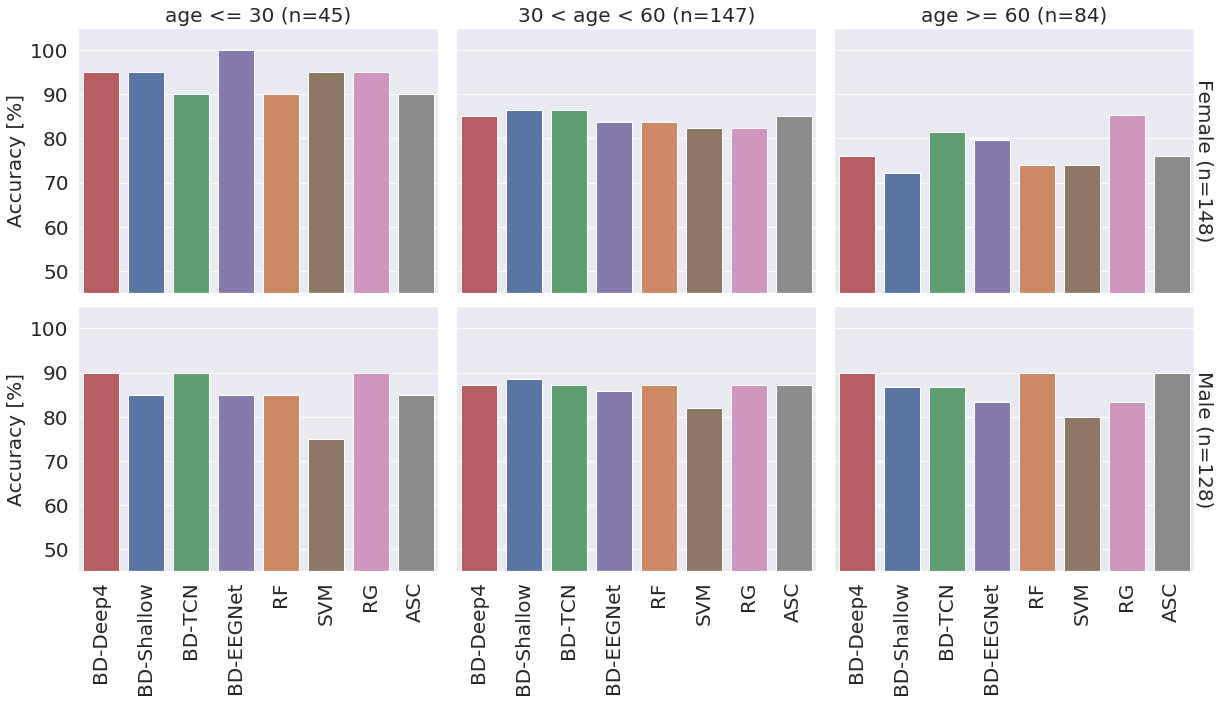

In [41]:
fig, ax_arr = plt.subplots(2, 3, figsize=(20,10), sharex=True, sharey=True)
ax  = ax_arr[0,0]
sub_df = df[(df["Age"] == "young") & (df["Gender"] == "female")]
sns.barplot(sub_df["Model"], sub_df["Accuracy [%]"], ax=ax, palette=palette)
ax.set_title("age <= {} (n={})".format(young_age, (ages <= young_age).sum()), fontsize=fs)
ax.set_xlabel("")
ax.yaxis.set_tick_params(labelsize=fs)
ax.set_ylabel("Accuracy [%]", fontsize=fs)
ax.set_ylim([45, 105])

ax  = ax_arr[0,1]
sub_df = df[(df["Age"] == "middle") & (df["Gender"] == "female")]
sns.barplot(sub_df["Model"], sub_df["Accuracy [%]"], ax=ax, palette=palette)
ax.set_title("{} < age < {} (n={})".format(young_age, old_age, ((ages > young_age) & (ages < old_age)).sum()), fontsize=fs)
ax.set_ylabel("")
ax.set_xlabel("")

ax  = ax_arr[0,2]
sub_df = df[(df["Age"] == "old") & (df["Gender"] == "female")]
sns.barplot(sub_df["Model"], sub_df["Accuracy [%]"], ax=ax, palette=palette)
ax.set_title("age >= {} (n={})".format(old_age, (ages >= old_age).sum()), fontsize=fs)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_ylabel("Female (n={})".format((genders==1).sum()), rotation=270, labelpad=-360, fontsize=fs)


ax  = ax_arr[1,0]
sub_df = df[(df["Age"] == "young") & (df["Gender"] == "male")]
sns.barplot(sub_df["Model"], sub_df["Accuracy [%]"], ax=ax, palette=palette)
ax.set_xlabel("")
ax.set_xticklabels(df.Model.unique(), rotation=90, fontsize=fs)
ax.yaxis.set_tick_params(labelsize=fs)
ax.set_ylabel("Accuracy [%]", fontsize=fs)

ax  = ax_arr[1,1]
sub_df = df[(df["Age"] == "middle") & (df["Gender"] == "male")]
sns.barplot(sub_df["Model"], sub_df["Accuracy [%]"], ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(df.Model.unique(), rotation=90, fontsize=fs)

ax  = ax_arr[1,2]
sub_df = df[(df["Age"] == "old") & (df["Gender"] == "male")]
sns.barplot(sub_df["Model"], sub_df["Accuracy [%]"], ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(df.Model.unique(), rotation=90, fontsize=fs)
ax.set_ylabel("Male (n={})".format((genders == 0).sum()), rotation=270, labelpad=-360, fontsize=fs)

plt.subplots_adjust(wspace=.05, hspace=.05)

fig.savefig("./subset_accuracies.pdf", bbox_inches="tight")